# Sentiment Analysis based on Twitter's perception of Liverpool's Goalkeeper, Adrian, during the Second Leg of the Round of 16 UCL tie

Data is taken from the Twitter Scrape. 
See the Twitter_Scrape directory for more information. 

In [59]:
import pandas as pd
import re
import numpy as np
import nltk

# Cleaning the Data

In [60]:
# checking the data from the database
initial_data = pd.read_csv("tweetsall.csv")
initial_data["date"] = pd.to_datetime(initial_data["date"])

In [61]:
# creating a function to clean up tweets
def remove(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [62]:
# creating a function to identify retweets
def retweet(input_txt):
    r = re.findall("RT \:", input_txt)
    for i in input_txt:
        if r:
            return 1
        else:
            return 0

In [63]:
# cleaning the data
cleaned_data = pd.DataFrame(columns= ["tid", "date", "tweet", "retweet"])
cleaned_data["tid"] = initial_data["tid"]
cleaned_data["date"] = initial_data["date"]
cleaned_data["tweet"] = np.vectorize(remove)(initial_data["text"], "@[\w]*")
cleaned_data["full_tweet"] = np.vectorize(remove)(initial_data["text"], "@[\w]*")
cleaned_data["full_tweet"] = cleaned_data["full_tweet"].str.replace('[^\w\s\#]','')
cleaned_data["full_tweet"] = cleaned_data["full_tweet"].str.replace('RT ','')
cleaned_data["retweet"] = np.vectorize(retweet)(cleaned_data["tweet"])
cleaned_data["tweet"] = cleaned_data["tweet"].str.replace('[^\w\s\#]','')
cleaned_data["tweet"] = cleaned_data["tweet"].str.replace('RT','')
cleaned_data["tweet"] = cleaned_data["tweet"].str.lower()
cleaned_data["tweet"] = cleaned_data["tweet"].str.replace('yeah','')

# this next line removes all words of length three characters or less
# I experimented with using this (tweet) compared to full_tweet, and decided in the end not to use it
cleaned_data["tweet"] = cleaned_data["tweet"].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
cleaned_data.head()

,tid,date,tweet,retweet,full_tweet
0,1238364325326225414,2020-03-13 07:20:37,think defense they were serious would have sal...,0,I think the defense if they were serious wou...
1,1238361932102537217,2020-03-13 07:11:06,adrián overheard jordan henderson that wished ...,1,Adrián overheard me say to Jordan Henderson t...
2,1238353313004912641,2020-03-13 06:36:51,only goal that actually adrians fault atletico...,1,Only goal that I can actually say was Adrians...
3,1238347160162369537,2020-03-13 06:12:25,riises goal painful karius mistake painful ger...,1,Riises own goal painful Karius mistake painf...
4,1238346965454389249,2020-03-13 06:11:38,dijk handled situation well avoided foot raced...,0,Can dijk handled d situation well avoided a f...


# Unsupervised Sentiment Analysis

In [64]:
# creating a dataframe for initial unsupervised sentiment analysis
results = pd.DataFrame(data=cleaned_data["tid"], columns=["tid", "date", 
                                "tweet", "afinn", "vader", "textblob"])

In [65]:
# sentiment analysis using Afinn
from afinn import Afinn
afn = Afinn(emoticons=True)
data = []
for tweet in cleaned_data["full_tweet"]:
    score = afn.score(tweet)
    data.append(score)
results["afinn"] = np.array(data)

In [66]:
# sentiment analysis using VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
data = []
for tweet in cleaned_data["full_tweet"]:
    score = analyzer.polarity_scores(tweet)
    data.append(score)
results["vader"] = np.array(data)

In [67]:
# sentiment analysis using textblob
from textblob import TextBlob
data = []
for tweet in cleaned_data["full_tweet"]:
    score = TextBlob(tweet).sentiment.polarity
    data.append(score)
results["textblob"] = np.array(data)

Text(0, 0.5, 'Sentiment')

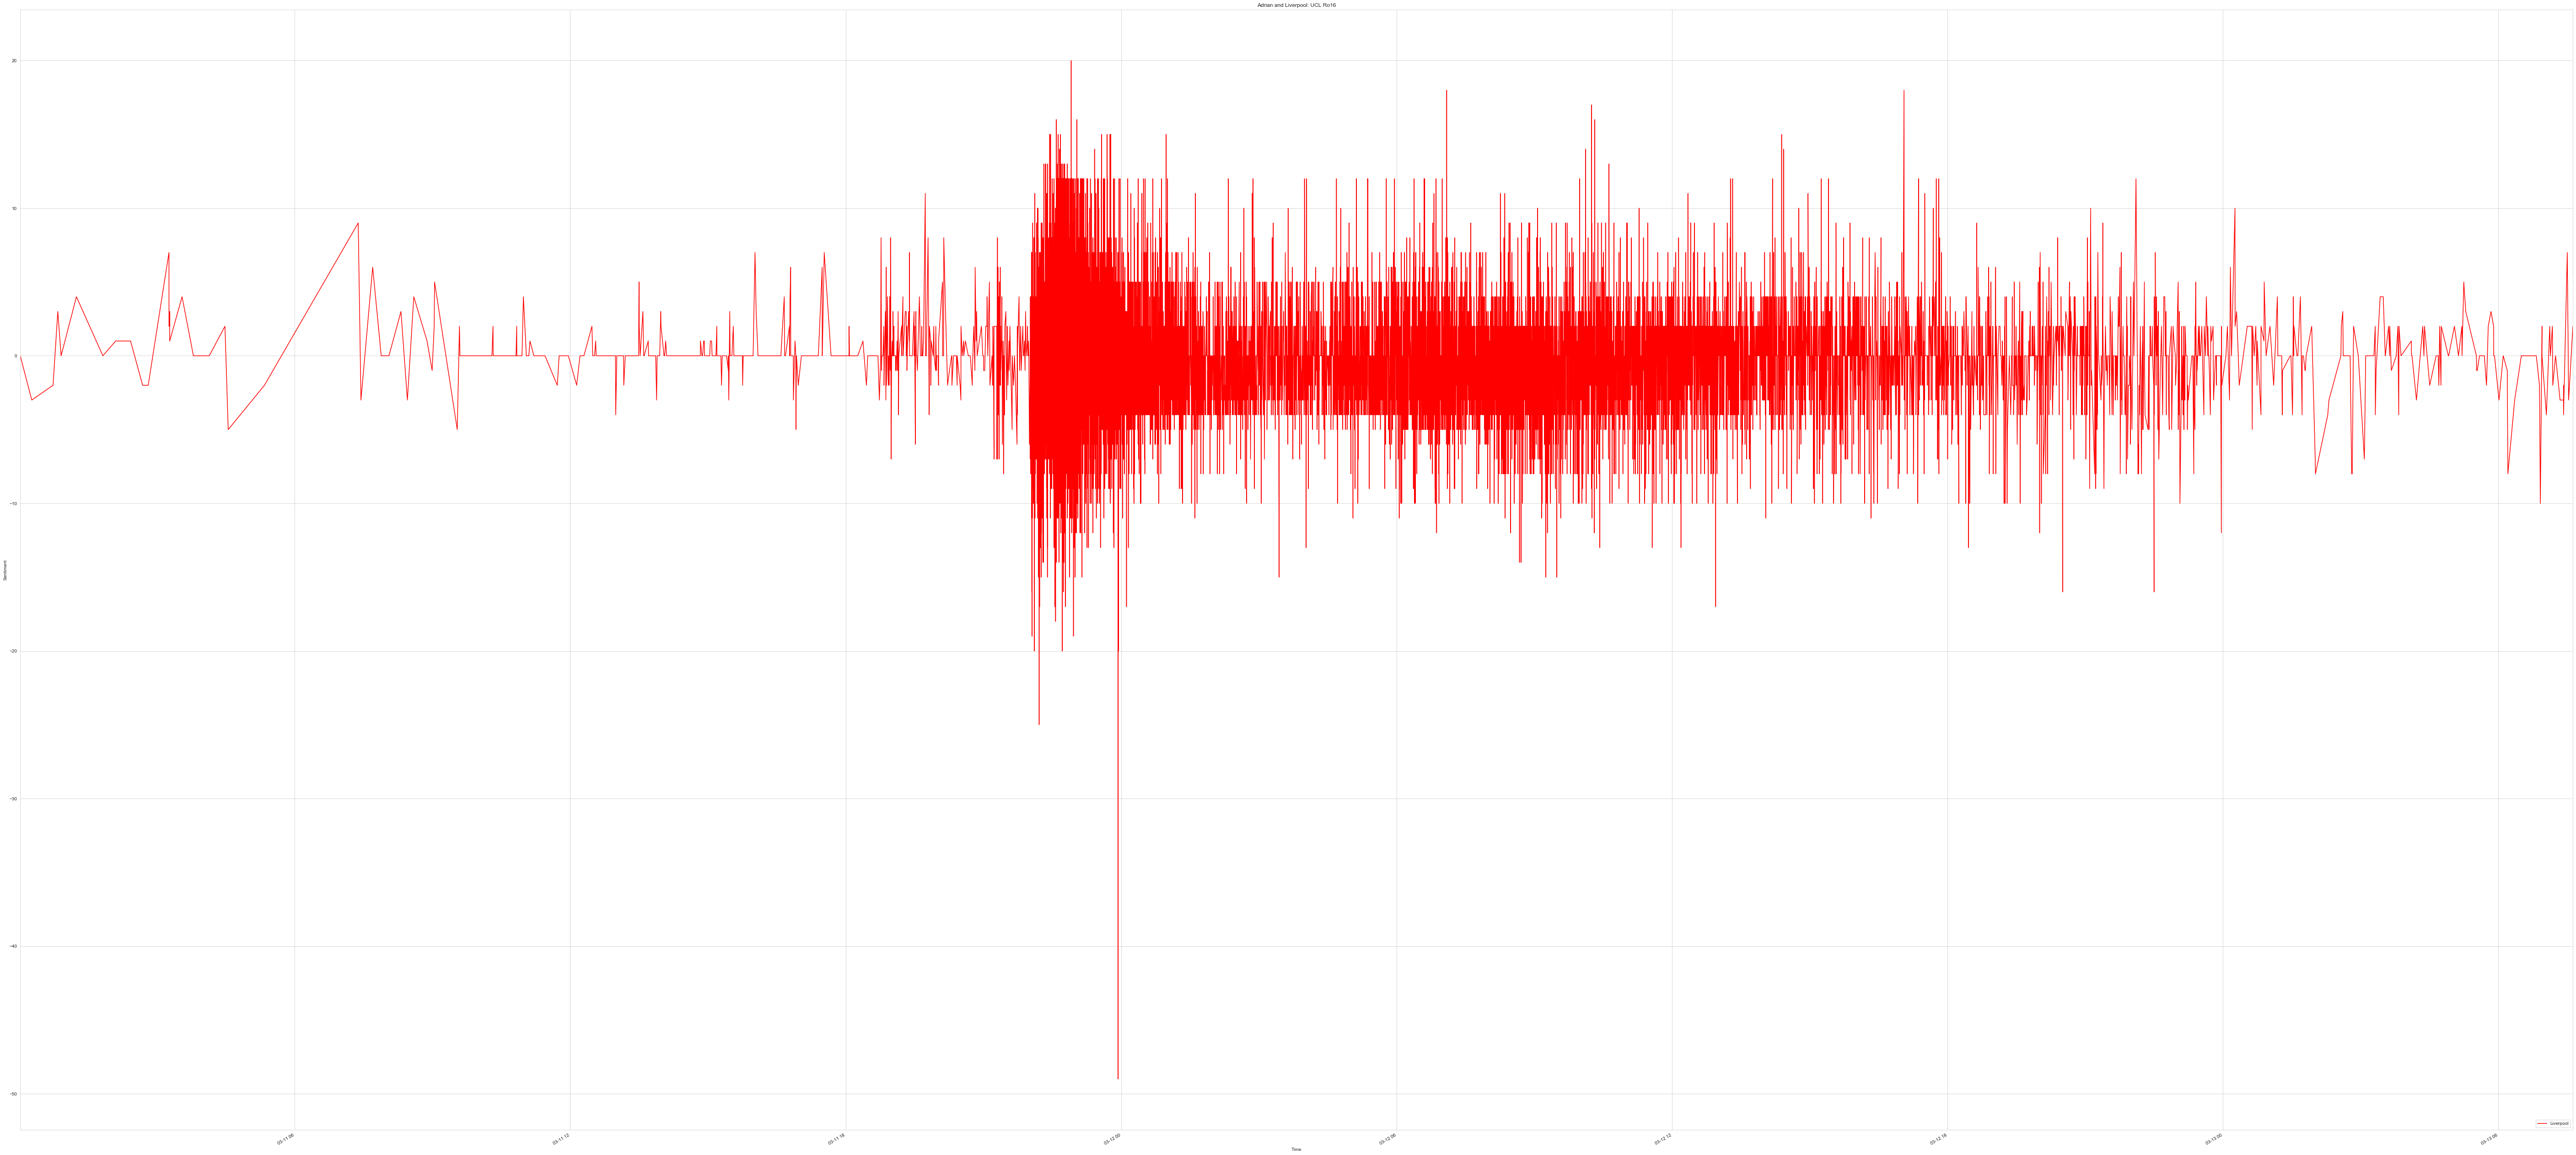

In [68]:
import matplotlib.pyplot as plt

# creating a dataframe for graphic visualisation of Afinn
results["date"] = cleaned_data["date"].astype("datetime64")
results.head()
graph = results.drop(["vader", "textblob"], axis=1)

# graph 
fig = plt.figure(figsize=(100, 50))
ax = fig.add_subplot(111)
ax.set_title('Adrian and Liverpool: UCL Ro16')
graph.plot(ax=ax, color='red', label='Liverpool', x="date", y="afinn")
ax.legend(loc='lower right')
ax.set_xlabel('Time')
ax.set_ylabel('Sentiment')

Text(0, 0.5, 'Sentiment')

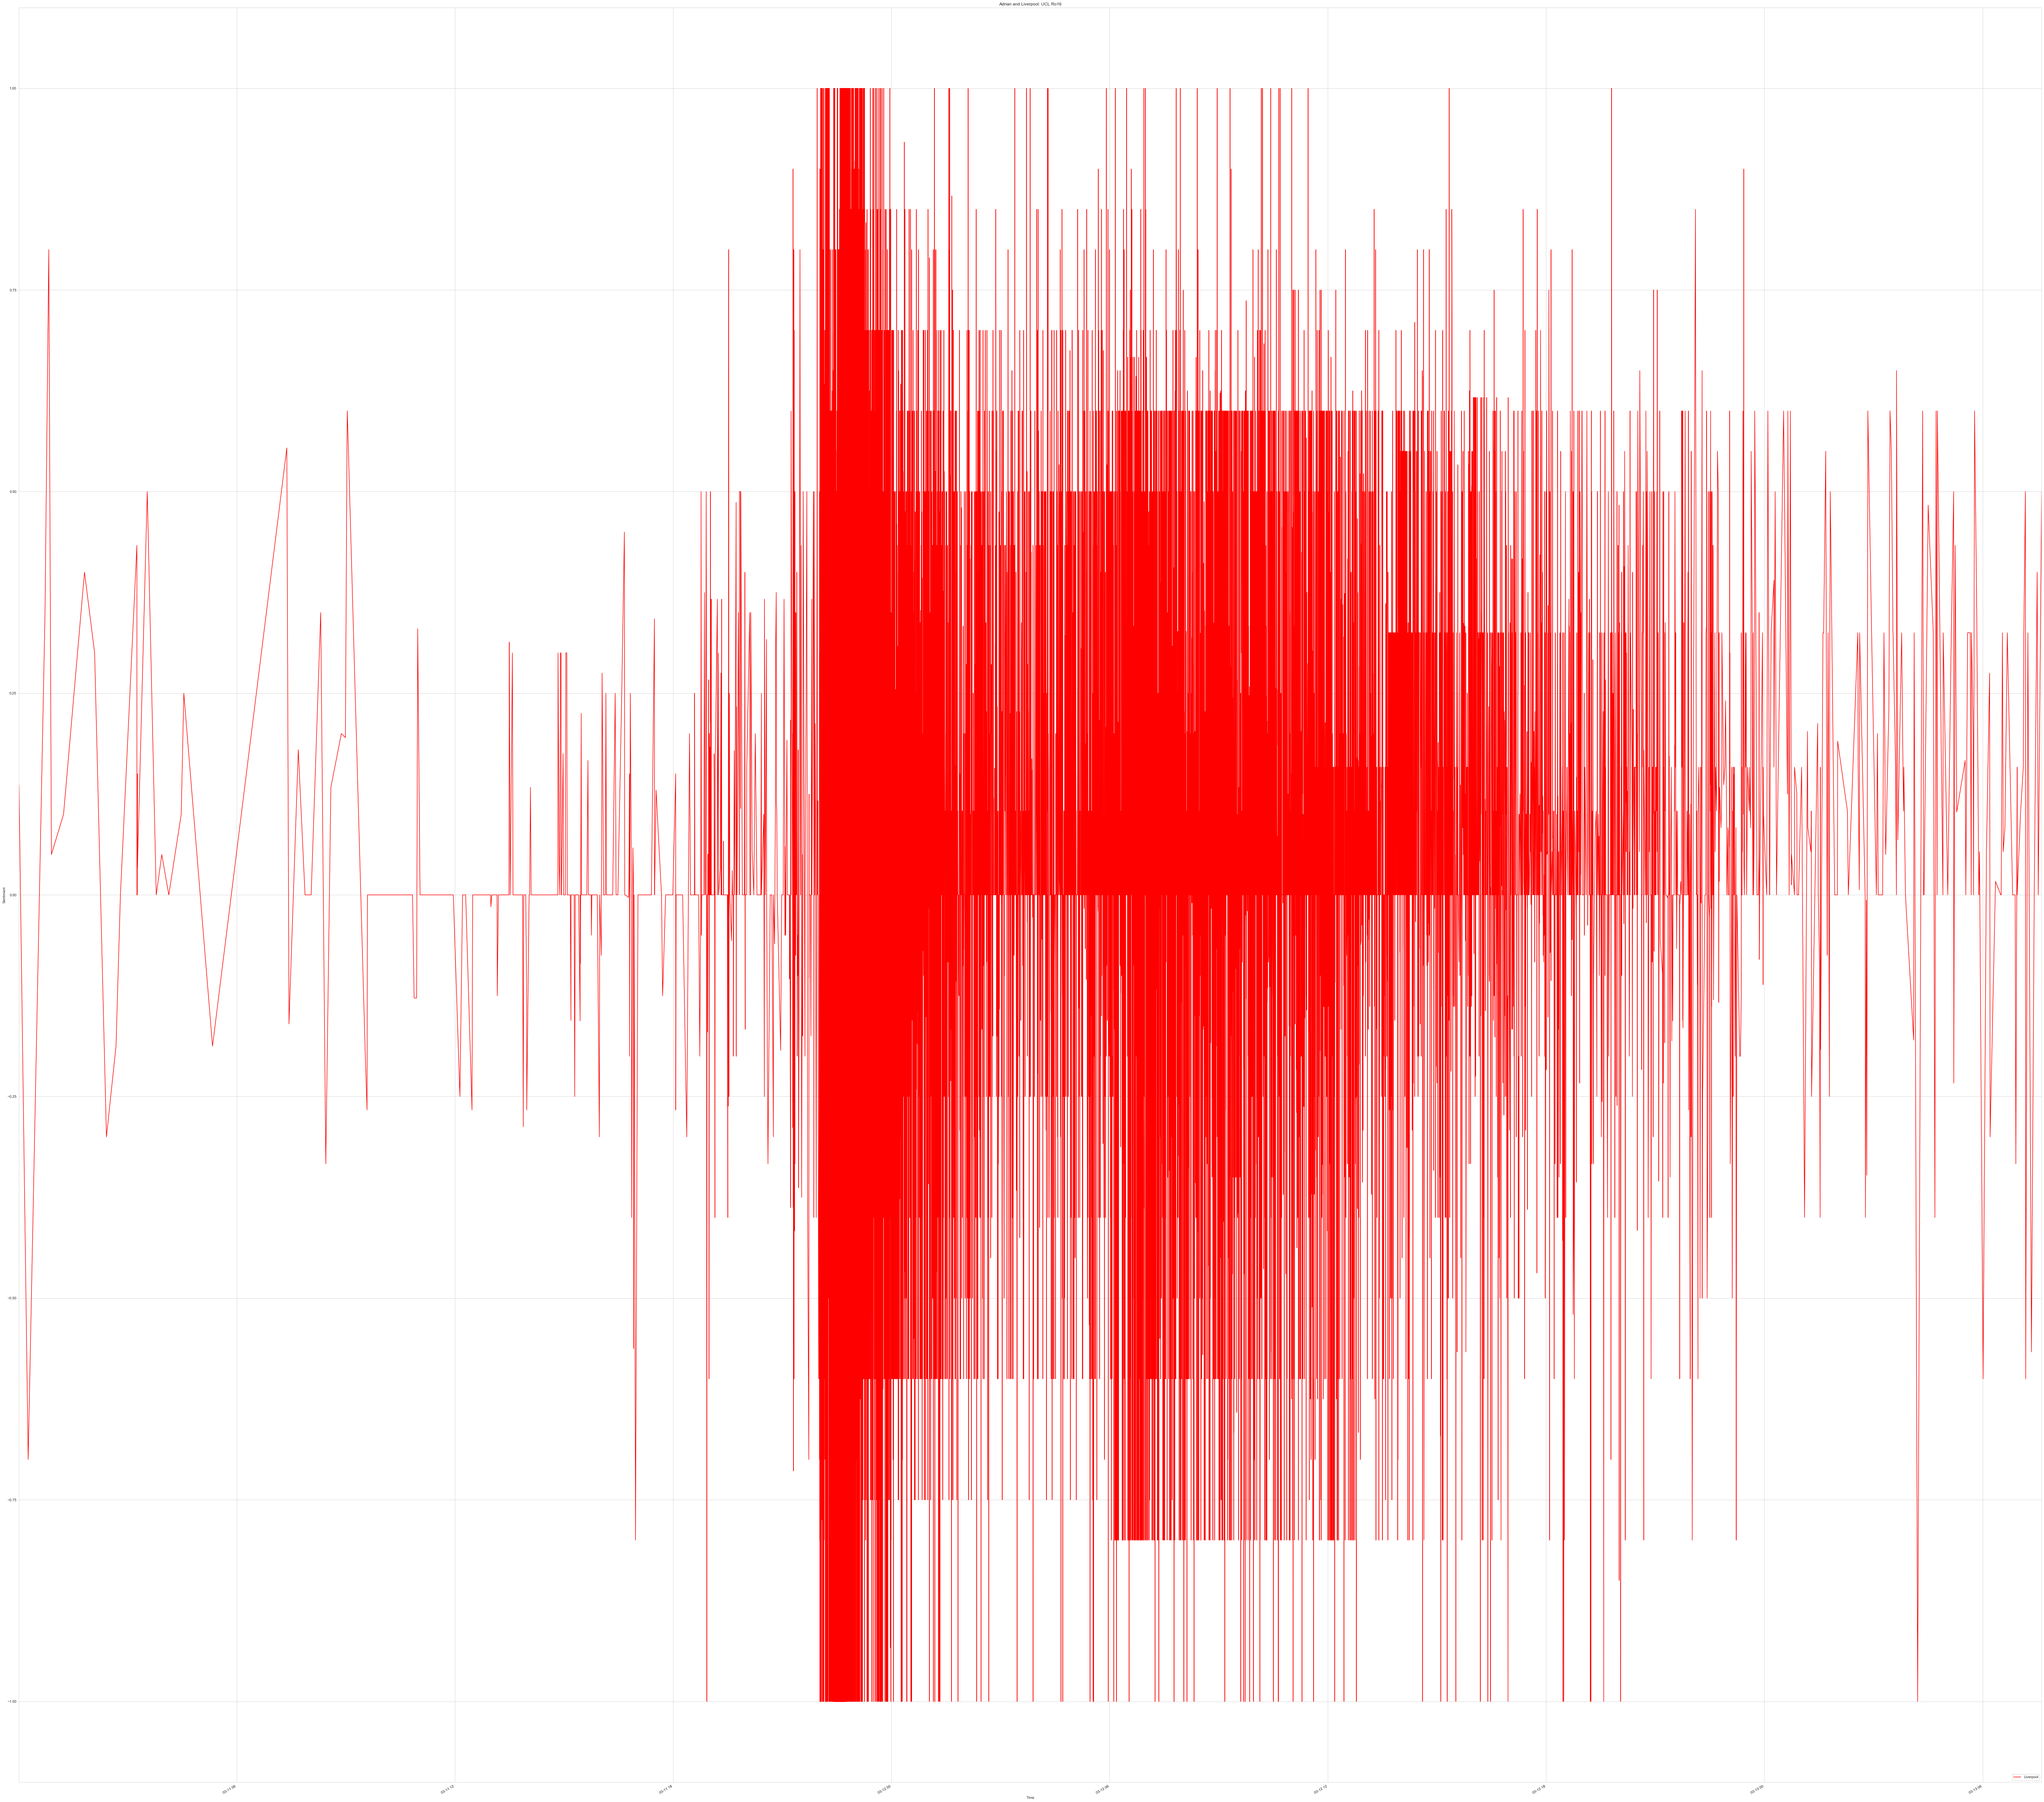

In [69]:
# creating a dataframe for graphic visualisation of textblob
graph = results.drop(["afinn", "vader"], axis=1)
graph.set_index("tid", inplace=True)

fig = plt.figure(figsize=(100, 100))
ax = fig.add_subplot(111)
ax.set_title('Adrian and Liverpool: UCL Ro16')
graph.plot(ax=ax, color='red', label='Liverpool', x="date", y="textblob")
ax.legend(loc='lower right')
ax.set_xlabel('Time')
ax.set_ylabel('Sentiment')

## Looking at a more exact time period: extra time in the game
### This is where Adrian's first big mistake occurred

In [70]:
# creting a dataframe for tweets during extra time only
condition1 = results["date"] > "2020-03-11 22:45:00"
condition2 = results["date"] < "2020-03-11 23:30:00"
et = results[condition1 & condition2].drop(["vader", "tweet"], axis=1)

In [71]:
from sklearn import preprocessing

# standardising afinn and textblob sentiment analysis for comparison
standardised_afinn = preprocessing.scale(et["afinn"])
standardised_tb = preprocessing.scale(et["textblob"])
et_standardised = et
et_standardised["afinn"] = standardised_afinn
et_standardised["textblob"] = standardised_tb

In [72]:
# re-introducing the additional information (tweets, tids, date) and removing retweeted tweets
mergedf = pd.DataFrame(columns=["tid", "retweet"])
mergedf["tid"] = cleaned_data["tid"]
mergedf["retweet"] = cleaned_data["retweet"]
retweetdf = pd.merge(left=et_standardised, right=mergedf, how="inner", 
         on="tid")
condition = retweetdf["retweet"] != 1
retweetdf = retweetdf[condition]

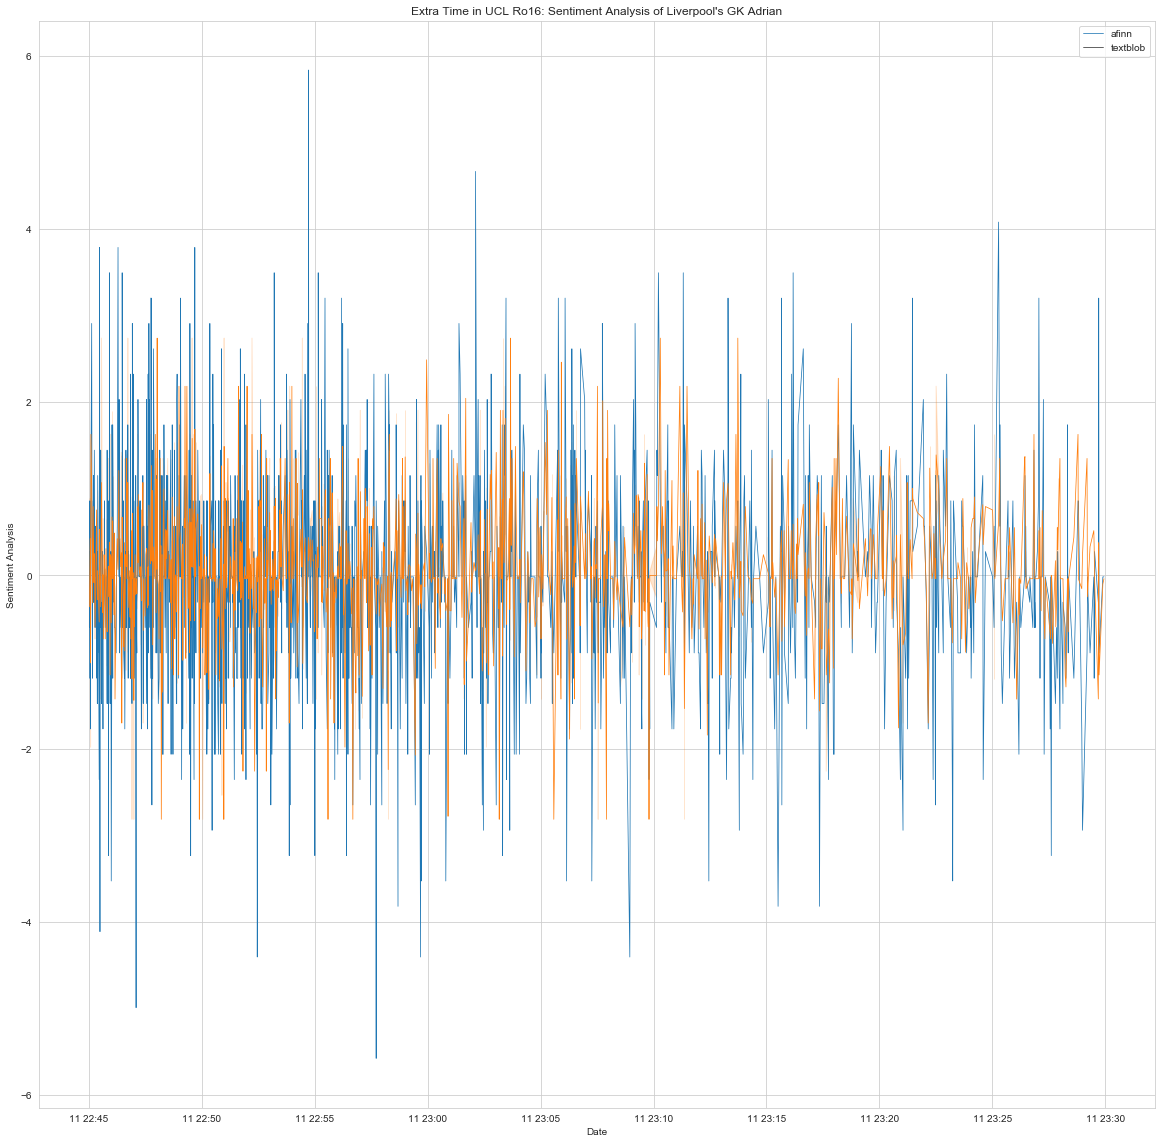

In [73]:
import seaborn as sns

# plotting both variables against each other
fig, ax = plt.subplots(figsize=(20,20))
sns.lineplot(retweetdf["date"], retweetdf["afinn"], ax=ax, size=0.5, estimator=None, err_style="bars")
sns.lineplot(retweetdf["date"], retweetdf["textblob"], ax=ax, size=0.5)

plt.legend(["afinn", "textblob"])
ax.set_title("Extra Time in UCL Ro16: Sentiment Analysis of Liverpool's GK Adrian")
ax.set_ylabel("Sentiment Analysis")
ax.set_xlabel("Date")
ax.autoscale()

# Analysis
- they seem to be broadly in line with each other
- afinn is more polarised/extreme on both the negative and positive scale
- the graph doesn't show us any specifics of how time affected perception of the goalkeeper;
- all throughout the period, there are positive and negative tweets regarding him 

# Creating our own supervised machine-learning driven approach

In [74]:
from textblob import Word

# lemmatize 
data = []
for i in cleaned_data["full_tweet"]:
    i = TextBlob(i)
    x = i.words
    y = x.lemmatize()
    data.append(y)
    
lemmatized = np.array(data)

In [75]:
# create dataframe from the lemmatized tweets
textblobdf = pd.DataFrame(data=cleaned_data)
textblobdf = textblobdf.drop(labels=["tweet", "full_tweet"], axis=1)
textblobdf["lemmatized"] = lemmatized
textblobdf["date"] = textblobdf["date"].astype("datetime64")
condition1 = textblobdf["date"] > "2020-03-11 22:45:00"
condition2 = textblobdf["date"] < "2020-03-11 23:30:00"
condition3 = textblobdf["retweet"] != 1
textblobdf = textblobdf[condition1 & condition2 & condition3]

# add a column called score for our sentiment value
textblobdf["score"] = None
textblobdf.head()

,tid,date,retweet,lemmatized,score
3512,1237883477158027268,2020-03-11 23:29:54,0,"[Well, it, actually, doesnt, happen, that, oft...",None
3516,1237883377446866945,2020-03-11 23:29:30,0,"[FACT, Anytime, a, Madrid, club, whip, Liverpo...",None
3522,1237883302029086727,2020-03-11 23:29:12,0,"[If, oblak, had, been, in, goal, for, u, and, ...",None
3528,1237883251483717632,2020-03-11 23:29:00,0,"[BBCsport, Blame, Adrian, for, defeat, but, wh...",None
3541,1237883084885778437,2020-03-11 23:28:20,0,"[Every, player, worked, their, sock, off, to, ...",None


### We need to manually teach our model what is negative and what is positive
### Using the standard dictionaries would return an approach as above, but we want to see what affect a self-taught model will have

In [76]:
import sklearn.model_selection as model_selection

# split into test and train
X = textblobdf["lemmatized"]
y = textblobdf["score"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.1)

In [77]:
# create a csv with our test data
interdf = pd.DataFrame(data=[X_train, y_train]).transpose()
interdf.to_csv("interdf.csv")

### I manually taught the model to classify a tweet as positive or negative using the test data
### I wrote these values in the csv (comma separated)
### The train size is low, due to having to manually teach the model
### An improvement would be to go back and to manually train on more than 10% of the data

In [78]:
# import trained data
df2 = pd.read_csv("traindata.csv")
traindata = pd.merge(df2, textblobdf, how="inner", left_on="Unnamed: 0", 
                right_on = textblobdf.index)
# drop unnecessary columns for the model
traindata = traindata.drop(axis=1, columns=["lemmatized_y", "score_y"])
#aesthetics
traindata.columns = ['index', 'lemmatized', 'score', 'tid', 'date', 'retweet']
traindata = traindata.dropna(subset=["score"])
traindf = traindata.reindex(columns=["lemmatized", "score", "tid", "date", "retweet"])

## Making Mistakes

- I could have used X_test, however I originally pulled too much data for X_train (train_size = 0,25)
- As I did not want to manually train a different set of data (due to shuffle), I decided to classify 100 tweets
- I then uploaded the entire tweet set (with 493 tweets), of which 100 had a sentiment classification
- I removed those without a sentiment classification from the train data#

## To improve, the creating of the train data should be done again with the correct ratios first time

### The below is a workaround to create the test data

In [79]:
# create a test set based on the rest of the data which is not in the train set
df_all = textblobdf.merge(traindf, on="tid", indicator=True, how="left")
testdf = df_all[df_all["_merge"] == "left_only" ]
testdf = testdf.drop(axis=1, labels=["lemmatized_y", "score_y", "date_y", "retweet_y", "_merge"])
testdf.columns = ['tid', 'date', 'retweet', 'lemmatized', 'score']
testdf = testdf.reindex(columns=["lemmatized", "score", "tid", "date", "retweet"])

In [80]:
# removing tokenization in preparation for running our model
nbtest = testdf[["lemmatized"]]

data = []
for row in testdf["lemmatized"]:
    separator = " "
    row = separator.join(row)
    data.append(row)
test = np.array(data)
test = pd.DataFrame(data=test)
test.head()

,0
0,Well it actually doesnt happen that often that...
1,FACT Anytime a Madrid club whip Liverpool they...
2,If oblak had been in goal for u and Adrian in ...
3,BBCsport Blame Adrian for defeat but why cant ...
4,Every player worked their sock off to gain the...


In [81]:
# Preparing the manually-trained train data for feeding to the model
nbtrain = traindf[["lemmatized", "score"]]
train = nbtrain.values.tolist()

### I beleive that Naive Bayes Classifier is the best model for this exercise
- it classifies based on predictors
- it is fast and powerful
- you don't need as much training data as compared to other models
- it's very good in text analysis

In [82]:
from textblob.classifiers import NaiveBayesClassifier
cl = NaiveBayesClassifier(train)

In [83]:
# running the model on test data
# we receive here three outputs: score (pos or neg), probablity of a positive sentiment, probability of a negative sentiment
data = []
data1 = []
data2 = []
for row in test[0]:
    score = cl.classify(row)
    data.append(score)
    pos = round(cl.prob_classify(row).prob("pos"), 2)
    data1.append(pos)
    pos = round(cl.prob_classify(row).prob("neg"), 2)
    data2.append(pos)
score_predicted = np.array(data)
prob_pos = np.array(data1)
prob_neg = np.array(data2)

In [84]:
# creating a dataframe of the tweets and their sentiment
testdf["score"] = score_predicted
data=[]
for row in testdf["lemmatized"]:
    separator = " "
    row = separator.join(row)
    data.append(row)
testdf["tweet"] = np.array(data)
resultdf = testdf.drop(axis=1, labels=["lemmatized"])
resultdf = resultdf.reindex(columns=["tid", "date", "tweet", "score"])
resultdf.index = resultdf["tid"]
resultdf = resultdf.drop(axis=1, labels=["tid"])
resultdf["prob_pos"] = prob_pos
resultdf["prob_neg"] = prob_neg
# creating a certainty score based on offseting prob_pos vs prob_neg
resultdf["certainty"] = resultdf["prob_pos"] - resultdf["prob_neg"]       
resultdf.head()

,date,tweet,score,prob_pos,prob_neg,certainty
tid,,,,,,
1237883477158027268,2020-03-11 23:29:54,Well it actually doesnt happen that often that...,pos,0.66,0.34,0.32
1237883377446866945,2020-03-11 23:29:30,FACT Anytime a Madrid club whip Liverpool they...,neg,0.00,1.00,-1.00
1237883302029086727,2020-03-11 23:29:12,If oblak had been in goal for u and Adrian in ...,neg,0.01,0.99,-0.98
1237883251483717632,2020-03-11 23:29:00,BBCsport Blame Adrian for defeat but why cant ...,neg,0.00,1.00,-1.00
1237883084885778437,2020-03-11 23:28:20,Every player worked their sock off to gain the...,neg,0.00,1.00,-1.00


In [85]:
# turning our certainty score into bins of certainty
# we must also remember that Naive Bayes has a tendency to not have the most accurate probability predcitions
# however, we generally need to see that a result is approaching towards 1, removing those below about 0.8
data = []
for row in resultdf["certainty"]:
    if row < 0:
        data.append(row * -1)
    else:
        data.append(row)
resultdf["certainty"] = np.array(data)
bins = [0.0, 0.5, 0.80, 0.9, 1.00]
labels = ["no confidence", "low confidence", "medium confidence", "high confidence"]
resultdf["binned_certainty"] = pd.cut(resultdf["certainty"], bins=bins, labels=labels)
resultdf.head()

,date,tweet,score,prob_pos,prob_neg,certainty,binned_certainty
tid,,,,,,,
1237883477158027268,2020-03-11 23:29:54,Well it actually doesnt happen that often that...,pos,0.66,0.34,0.32,no confidence
1237883377446866945,2020-03-11 23:29:30,FACT Anytime a Madrid club whip Liverpool they...,neg,0.00,1.00,1.00,high confidence
1237883302029086727,2020-03-11 23:29:12,If oblak had been in goal for u and Adrian in ...,neg,0.01,0.99,0.98,high confidence
1237883251483717632,2020-03-11 23:29:00,BBCsport Blame Adrian for defeat but why cant ...,neg,0.00,1.00,1.00,high confidence
1237883084885778437,2020-03-11 23:28:20,Every player worked their sock off to gain the...,neg,0.00,1.00,1.00,high confidence


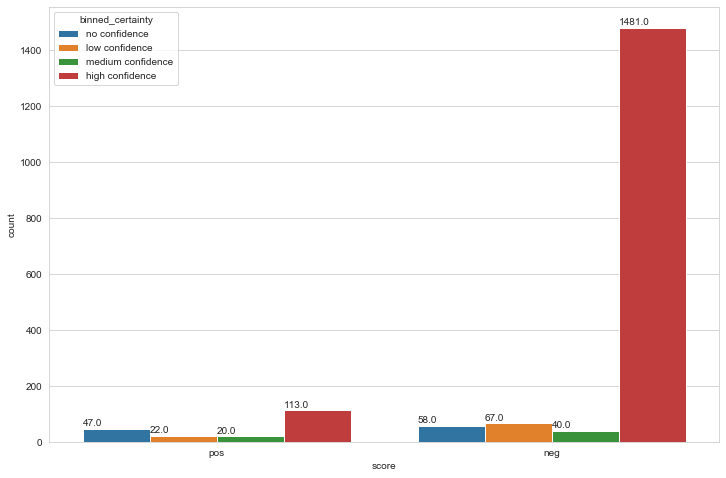

In [86]:
import seaborn as sns

# creating a bar graph visualisation of the data
bar = resultdf.drop(["tweet"], axis=1)
plt.figure(figsize=(12,8))
ax = sns.countplot(x="score", data=bar, hue="binned_certainty")
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x(), p.get_height()+10))

In [87]:
# creating a dataframe where we remove all results that aren't high or medium confidence
condition1 = resultdf["binned_certainty"] == "high confidence"
condition2 = resultdf["binned_certainty"] == "medium confidence"
confidentdf = resultdf[condition1 | condition2]

In [88]:
# creating a new dataframe for a visualisation over time of the sentiment
data = []
for row in confidentdf["prob_neg"]:
    data.append(row * -1)

confidentdf["score_numerical"] = np.array(data)
confidentdf["score_numerical"] = confidentdf["score_numerical"] + confidentdf["prob_pos"]
timenegdf = confidentdf.drop(labels=["tweet", "score", "prob_pos", "prob_neg", "certainty"], axis=1)
timenegdf.head()

/Users/oliverbains/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/oliverbains/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,date,binned_certainty,score_numerical
tid,,,
1237883377446866945,2020-03-11 23:29:30,high confidence,-1.00
1237883302029086727,2020-03-11 23:29:12,high confidence,-0.98
1237883251483717632,2020-03-11 23:29:00,high confidence,-1.00
1237883084885778437,2020-03-11 23:28:20,high confidence,-1.00
1237883002543194113,2020-03-11 23:28:01,high confidence,-1.00


In [89]:
# creating the same dataframe and filtering out for positive and negative sentiment 
posdf = timenegdf[timenegdf["score_numerical"] > 0]
negdf = timenegdf[timenegdf["score_numerical"] < 0]

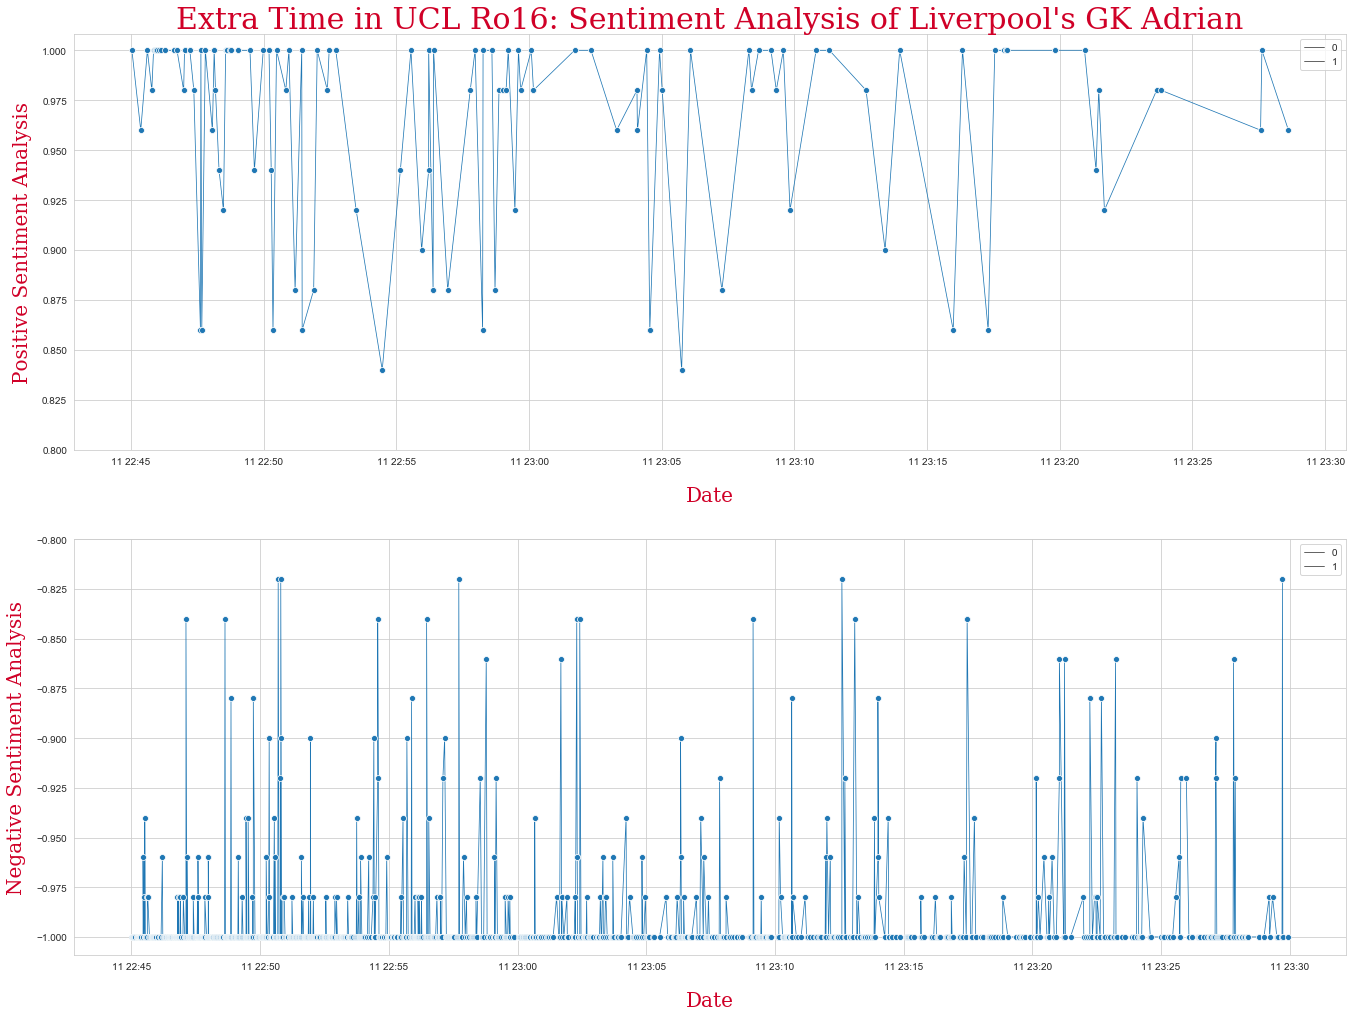

In [90]:
# creating the graph of sentiment over time
# one graph for positive sentiment, one for negative
# this allows a less cluttered approach

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(20,15))
fig.tight_layout(pad=7.0)
sns.set_style("whitegrid")
ax1 = sns.lineplot(posdf["date"], posdf["score_numerical"], ax=ax1, size=1, 
             estimator=None, marker='o')
ax2 = sns.lineplot(negdf["date"], negdf["score_numerical"], ax=ax2, size=1, 
             estimator=None, marker='o')

xaxes = {"fontsize": 20,
    "fontweight" : 10,
    "verticalalignment": "top",
    "family" : "serif",
    "color" : "#D00027"}
yaxes = {"fontsize": 20,
    "fontweight" : 10,
    "family" : "serif",
    "color" : "#D00027"}
title = {"fontsize": 30,
    "fontweight" : 10,
    "family" : "serif",
    "color" : "#D00027"}


ax1.set_title("Extra Time in UCL Ro16: Sentiment Analysis of Liverpool's GK Adrian", fontdict=title)
ax1.set_ylabel("Positive Sentiment Analysis", fontdict=yaxes)
ax1.set_xlabel("Date", fontdict=xaxes)
ax1.set_ylim(bottom=0.8)
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 10

ax2.set_ylabel("Negative Sentiment Analysis", fontdict=yaxes)
ax2.set_xlabel("Date", fontdict=xaxes)
ax2.set_ylim(top=-0.8)
ax2.xaxis.labelpad = 20
ax2.yaxis.labelpad = 10

# Analysis

### We can see that there are many more instances of negative sentiment than positive
### The confidence level of the classification of this sentiment is also similar for both (the negative sentiment appears to be more confident purely due to the larger amount of data)
### The mistake happened at 23.01 UTC
- we can see a large number of negative tweets at this time
- the confidence of the sentiment these tweets is very high
- additionally, we have almost no positive sentiment tweets in this time
- the number of positive sentiment tweets after the first mistake are less compared to those before. The positive sentiment tweets after are very sparse.
- the confidence level of postive sentiment seems to drop off very slightly after the mistake, but this could also be simply due to the fewer positive sentiment tweets creating this visual affect. In addition, we must remember that we removed all "low" and "no" confidence tweets from this graph